In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from ParamsShaker import ParamsShaker
from torch.optim.lr_scheduler import StepLR

import random

# ParamsShaker

Here, we will train a simple model with the shaker.
To evaluate the performance of the class, we will train the same model without the shaker

- make a simple model

In [3]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)



- We will use this function for the better comparison

In [4]:
def set_seed(seed_value):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


- make a simple problem

In [6]:
X = torch.linspace(-10, 10, 1000).unsqueeze(1)
y = X.sin()

train_size = int(0.8 * len(X))
X_train, X_val = torch.split(X, [train_size, len(X) - train_size])
y_train, y_val = torch.split(y, [train_size, len(y) - train_size])

- train a simple model with a shaker

100%|██████████| 2000/2000 [00:03<00:00, 502.17it/s]


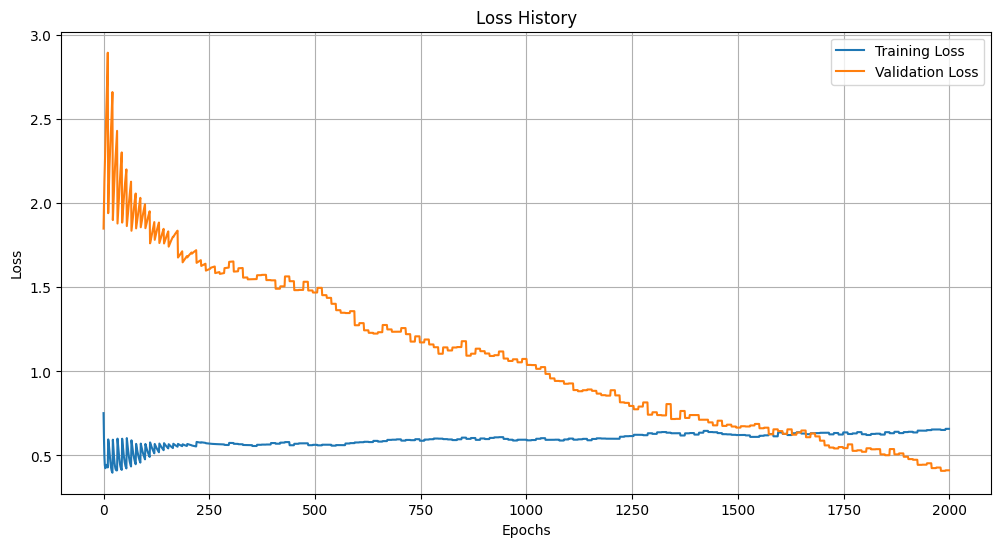

In [7]:
set_seed(42)

model = SimpleNet()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
step_scheduler = StepLR(optimizer, step_size=2, gamma=0.95)

shaker = ParamsShaker(model=model, patience=10, threshold=0.00001, shake_std=0.001)

num_epochs = 2000
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
    step_scheduler.step()
    shaker.step(val_loss.item())

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

- train the same model, but without a shaker 

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 572.70it/s]


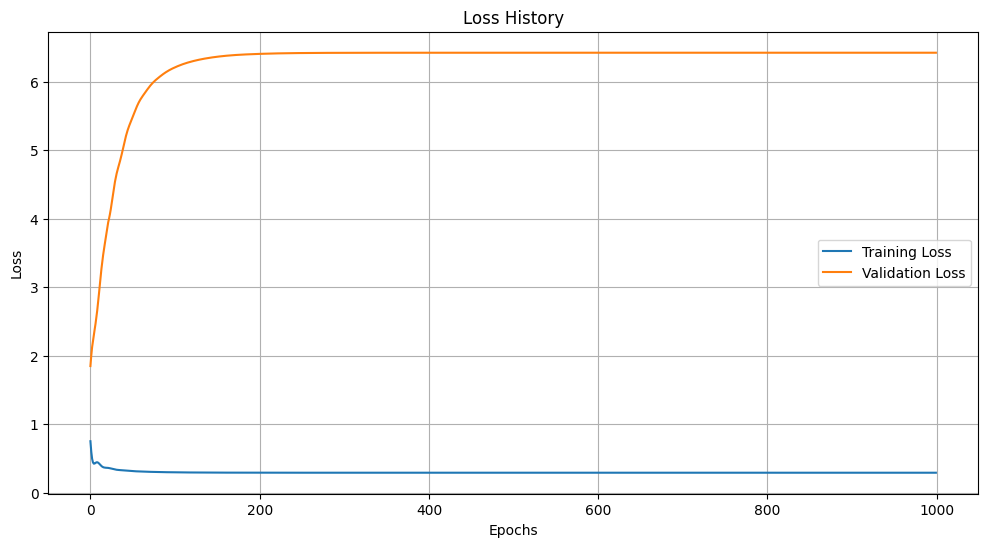

In [11]:
set_seed(42)

model = SimpleNet()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
step_scheduler = StepLR(optimizer, step_size=2, gamma=0.95)

num_epochs = 1000
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
    step_scheduler.step()

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

- Pros

The model with shaker converges to, maybe, the global minimum.

The training process diverged several times, but the shaker introduced a new starting point whenever it diverged,
and eventually converged.

Compare with the training without a shaker.

- Cons

From the loss plot, we have the crosssection between train and val losses.
It strongly implies the danger of overfitting. 